Preamble and imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Ridge regression and learning operators

You've likely encountered linear regression before in the context of fitting lines to data; it represents an interpretable "null hypothesis" model for finding trends in data. However, here we want to think a little more about how to interpret and understand linear regression, and so we will study a different context: learning approximate dynamical models directly from observations. 

### The Navier-Stokes equations

The full Navier-Stokes equations comprise a parabolic set of partial differential equations describing the evolution of a velocity field $\mathbf{u}$,
$$
\rho\left(\dfrac{\partial \mathbf{u}}{\partial t} + \mathbf{u} \cdot \nabla \mathbf{u}       \right) = -\nabla p + \mu \nabla \cdot \left(    (\nabla \mathbf{u} + (\nabla \mathbf{u})^T) - \dfrac{2}{3} (\nabla \cdot \mathbf{u})\mathbf{I}          \right) + \mathbf{F}
$$
This equation describes several interacting phenomena. The first parenthetical term proportional to the local density $\rho$ corresponds to inertial forces, while the second term corresponds to pressure gradients in the fluid. The term proportional to the viscousity, $\rho$, represents the effect of viscous drag within the fluid, while the forcing term $\mathbf F$ corresponds to external forces.

We usually supplement this partial differential equation with an additional equation describing conservation of momentum,
$$
\dfrac{\partial \rho}{\partial t} + \nabla \cdot (\rho \mathbf{v}) = 0.
$$
Note that the full Navier-Stokes equations describe the dynamical evolution of three coupled fields: the velocity field $\mathbf{u}$, the local density $\rho$, and the pressure $p$. Usually, we will not attempt to directly solve the full equations, but instead we will first reduce these equations to a more specific form based on constraints or symmetries relevant to a specific problem. For example, when working with water or other liquids we usually assume the incompressibility condition $\nabla \cdot \rho = 0$

If our flow has a characteristic length scale $L$ and velocity scale $U$, we can non-dimensionalize the Navier-Stokes equations by performing the substitution $\mathbf{u} \leftarrow \mathbf{u} / U$, $\mathbf{r} \leftarrow \mathbf{r} / L$, $\nabla \leftarrow L \nabla$, $t \leftarrow t (U / L)$, $p \leftarrow p / (\rho U^2)$, producing the non-dimensionalized Navier-Stokes equations
$$
{\frac {\partial \mathbf {u} }{\partial t}}+(\mathbf {u} \cdot \nabla)\mathbf {u} \ =-\nabla p+{\frac {1}{Re}}\nabla^{2}\mathbf {u}.
$$
where the non-dimensional Reynolds number $Re \equiv \rho U L / \mu$. The Reynolds number quantifies the ratio of inertial to viscous forces in the system. At large $Re$, the advective terms dominate the Navier-Stokes equations, while the Laplacian term associated with dissipation vanishes. The resulting inertia-dominated equations, known as the Euler equation for ideal (frictionless) fluids, give rise to turbulence in fast-moving classical fluids at large length scales (the Euler equation also approximates the dynamics of superfluids, for similar reasons). At very small $Re$, however, friction dominates the system, leading to the Stokes equations. This overdamped dynamical regime describes [many biological systems](http://www.damtp.cam.ac.uk/user/gold/pdfs/purcell.pdf), and it [many counterintuitive phenomena](https://www.youtube.com/watch?v=UpJ-kGII074) arise due to the appearance of time-reversal symmetry in the underlyingequations.



## Ridge regression

### The vortex street revisited

We've already seen the von Karman vortex street in a previous homework assignment. This fluid flow corresponds a uniform flow moving over a cylinder. The velocity scale of this system, $U$, is set by the speed at which the fluid passes over the cylinder, while the length scale $L$ is the length of the cylinder. We normally see the vortex street instability first appear in the wake when $Re \gtrsim 100$. 

In our previous homework, we saw that the von Karman dataset comprises a series of snapshots of a two-dimensional velocity field, with separate datasets corresponding to different Reynolds numbers. We want to train a model that predicts the next snapshot of the flow field, $\mathbf{v}_{t+1}$, given only the current snapshot $\mathbf{v}_t$ as an input.
Our general learning problem has the form 
$$
\mathbf{v}(\mathbf{r})_{t + 1} = \mathbf{f}(\mathbf{v}(\mathbf{r})_{t})
$$
where $\mathbf{f}$ is the function that we are attempting to learn. While there are a variety of methods for learning the function $\mathbf{f}$, we will start by attempting to learn a linear model,
$$
\mathbf{v}(\mathbf{r})_{t + 1} = \boldsymbol{\theta} \cdot \mathbf{v}_{t}
$$
This problem is challenging because the Navier-Stokes equations are not linear in $\mathbf{v}$. In other words, by fitting a linear model to the snapshot time series, we attempt to approximate a highly nonlinear PDE with a linear model. We suspect that this approximation may work better over short timescales, for which $\mathbf{v}(\mathbf{r})_{t + 1} - \mathbf{v}_{t} \approx \partial \mathbf{u}/\partial t$

We can treat this problem as a regression problem, where our data matrix $X$ represents a stack of snapshots of the velocity field at different times, $X^T = [\mathbf{v}_1\;\mathbf{v}_2\;\cdots\mathbf{v}_{N-1}]$. While we are working with time series data, we will treat each snapshot as if it were an independent sample of a set of features---our regression results will be invariant to random shuffles of the input velocity field time series. In a more sophisticated approach, we might consider taking the ordering information into account in our regression. Our regression target, $Y$, represents the values of the velocity field at the next point in time, because our model will attempt to just predict the next step ahead in the process. For this reason, our labels or targets represent the matrix $Y^T = [\mathbf{v}_2\; \mathbf{v}_3\;\cdots\mathbf{v}_N]$. We emphasize that this regression problem is identical to standard linear regression, where we predict an outcome $y$ based on a set of input features $X$. Our forecasting problem is unique only in that $X$ and $Y$ happen to have the same dimensionality, since they are snapshots of a velocity field.

There's one hiccup in our approach: our input data is extremely high-dimensional. If we think of our input $X$ as a design matrix $X \in \mathbb{R}^{N_{data} \times N_{features}}$, then number of features is extremely large $N_{features} = 2 \cdot N_x \cdot N_y$, because we have x- and y- velocity components on each site of an $N_x \times N_y$ lattice. That means that we might find ourselves in the limit $N_{data} < N_{features}$, in which case the problem is underdetermined: there are multiple values of $\boldsymbol \theta$ that will maximize the accuracy of our model. As a tiebreaker, we will use the Ridge, or Tikhonov criterion: we select the solution parameter vector $\boldsymbol \theta$ with the lowest norm.

Putting our goals together, we arrive at a loss function describing the problem that we want to solve,
$$
\mathcal{L}(\boldsymbol{\theta}) = || X \boldsymbol{\theta} - \mathbf{y} || + \lambda \boldsymbol{\theta}^T \boldsymbol{\theta}
$$
where $\lambda$ is a hyperparameter that determines how much we penalize the total weight vector. We wish to minimize this objective function with respect to the parameter matrix $\boldsymbol{\theta}$. This means that we want to solve the linear equation $\frac{\partial\mathcal{L}(\boldsymbol{\theta})}{\partial \boldsymbol{\theta}} = 0$ for $\boldsymbol{\theta}$.  Note that while the loss function is a scalar, we are taking its derivative with respect to a tensor $\boldsymbol{\theta}$. After some linear algebra, we arrive at the following closed-form expression for the value of the weight vector
$$
\boldsymbol{\theta} = (X^T X + \lambda \mathbb{I})^{-1} X^T \;Y
$$
In the case $\lambda = 0$, our problem reduces to the ordinary least-squares (OLS) formula. In the case where we have large numbers of features, the ridge penalty is necessary to ensure that our problem has a unique solution. Even if $N_{samples} > N_{features}$, we might still prefer to use ridge regression to ordinary least squares, because ridge regression favors more parsimonious solutions, that avoid excessively weighting certain features.




## To Do

+ Derive the ridge regression formula shown above. You may find some of the linear algebra tricks we saw in the [matrix cookbook](https://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf) helpful here.
+ Implement a Ridge Regression model and predict the next values of the Navier-Stokes equations. You should download the [von Karman dataset](https://utexas.box.com/s/44f89zfy7v2k4g5wq4kv3vfvkm9w91wm) and place it in the top-level directory `cphy/resources/`. I've included an object below that will handle creating train/val/test splits for you, and I've also included placeholder code to get you started on the regression model. For now, just implement the "global" solution method to the ridge regression problem. You can implement an iterative solution if you want to try something harder.
+ You'll notice that my train/test split in the ForecastingDataset object ensures that the test data occurs after the training data in the time series, and that no data points are repeated. Why do you think this is important for this problem?
+ Our model has a single hyperparameter, the regularizer strength $\lambda$, that determines the degree to which the weight entries in the regression matrix are penalized. Using the validation fold of our training dataset, find the best value of that hyperparameter.
+ (Hard) We are treating our forecasting problem like a black box regression problem---we seek to find a linear map between two vectors, which happen to be flattened snapshots of the velocity field. However, since we know that our problem is a fluid flow, we can exploit our domain knowledge to improve how our model sees the data---in the language of ML, we can improve our model with an "inductive bias." From the numerical integration homework, we know that solving spatial PDEs involves calculating discrete Laplace operators, or taking the spatial Fourier transform. Using my code outlined below, implement a function that featurizes each snapshot of a velocity field array by adding spatial gradients and frequencies as features. Re-run your forecasting with this improved featurization of the data.
+ Repeat your experiments using datasets with different Reynolds numbers. How does forecast accuracy generally change with Reynolds number?
+ There are plenty of other ways to solve a regression problem. In the last code cells below, we use implementations of several regression models included in the Python package scikit-learn. Check out how these models perform. Are there any surprises? Look up some background info on the models that seem to perform particularly well. Why do you think they work so well on this problem?

## Optional advanced problems

+ You'll notice that we downsampled our velocity field data. That's because the matrix operations needed to calculate the weight matrix become burdensome when the dataset is sufficiently large. Instead of directly solving our objective function with matrix algebra, we can instead iteratively solve it using gradient descent. Try implementing a gradient descent solution to the linear regression problem. For my version of the solution, I added a private method to the LinearRegressor object, and a keyword argument to the constructor that chooses between global and iterative solving. 
+ If you want to even further improve your iterative method, try adding momentum and adaptive step size to your gradient descent. Here are [some examples of common optimizers](https://www.kdnuggets.com/2020/12/optimization-algorithms-neural-networks.html) used to train machine learning models like neural networks
+ A more advanced problem: Instead of the ridge penalty, we can use the Lasso, or L1, regularization term: $$\mathcal{L}(\theta) = \sum_{i} |\theta_i|$$. This is a little bit trickier to implement than ridge regression, because the loss is not differentiable at $0$.
+ A mathematical problem: We essentially fit a linear operator $\mathbf{v}_{t + 1} = A \mathbf{v}_{t}$. Starting from the non-dimensional Navier-Stokes equations, derive an expression for the leading order linear behavior of the equations, as well as the first-order nonlinear term $\mathcal{O}(\mathbf{v} \cdot \mathbf{v})$. How does accuracy of the linear approximation depend on the Reynolds number?

## Additional information

<!-- + There are lots of summaries of the Navier-Stokes equations, their reductions, and the kinds of approximations that people use to numerically solve them. I find the description of the [NS equations in the COMSOL documentation](https://www.comsol.com/multiphysics/navier-stokes-equations) to have some of the most consistent notation and concise exposition that I've found. -->
+ Applications of deep learning to flow field modelling and prediction is an active area of research. One of my favorite papers in this area highlights [physics-informed neural networks](https://www.science.org/doi/abs/10.1126/science.aaw4741), where the same differentiability that faciliates gradient descent also allows calculation of gradient terms in the governing equations for the fluid flow.
+ Our ridge regression penalty represents a form of *regularization*, which helps prevent our model from overfitting. The ridge regularizer is commonly used even for more sophisticated models like deep neural networks, in order to constrain solutions to have simpler forms (even at the expense of overall accuracy). Many other regularizers exist, which serve to encourage certain desiderata in model space, such as representational uniqueness or sparsity.

Velocity field data has shape: (375, 64, 32, 2)


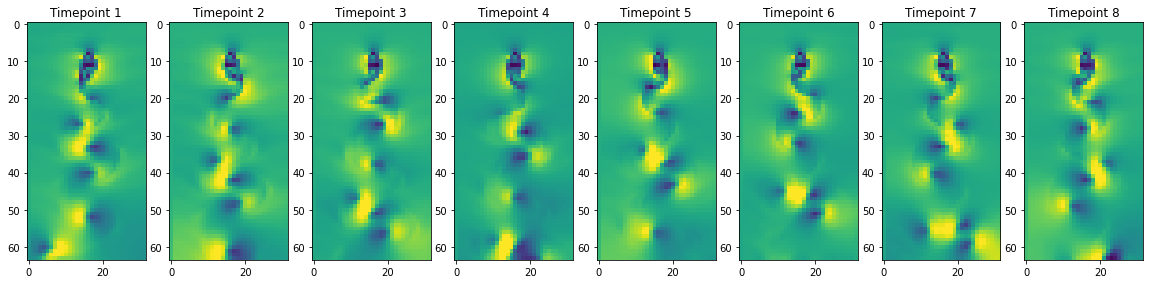

In [2]:

## Load the velocity field data

Re = 600 # Reynolds number, change this to 300, 600, 900, 1200

# Load the two-dimensional velocity field data. Data is stored in a 4D numpy array,
# where the first dimension is the time index, the second and third dimensions are the
# x and y coordinates, and the fourth dimension is the velocity components (ux or uv).
vfield = np.load(
    f"../resources/von_karman_street/vortex_street_velocities_Re_{Re}_largefile.npz", 
    allow_pickle=True
)
# downsample the data for faster training
vfield = vfield[::8, ::4, ::4]
print("Velocity field data has shape: {}".format(vfield.shape))

# Compute the velocity magnitude
vfield_mag = np.sqrt(vfield[..., 0]**2 + vfield[..., 1]**2)

n_tpts = vfield.shape[0]
plt.figure(figsize=(20, 10))
for i in range(8):
    plt.subplot(1, 8, i+1)
    v_vals = vfield_mag[n_tpts // 8 * i]
    plt.imshow(v_vals, cmap="viridis", vmin=0, vmax=np.percentile(v_vals, 99))
    plt.title("Timepoint {}".format(i + 1))

In [3]:
class ForecastingDataset:
    """
    A class for formatting time series data for forecasting.
    By convention, time is assumed to be the first dimension of the dataset.

    For time series data, it is very important that all data in test set is after 
    all data in the train and val sets. We also need to ensure that datapoints don't
    appear in multiple splits. 

    Parameters
        X (np.ndarray): The time series data. The first dimension is assumed to be time.
        split_ratio (tuple): The ratio of the data to be used for train, val, and test.
        forecast_horizon (int): The number of time steps to forecast at once
        featurizer (callable): A function that takes in multivariate snapshot and 
            returns a feature vector. If None, the raw data is used.
    """

    def __init__(self, X, split_ratio=(0.6, 0.2, 0.2), forecast_horizon=1, featurizer=None):

        if featurizer is None:
            self.featurizer = lambda x: x
        else:
            self.featurizer = featurizer

        self.feature_shape = X.shape[1:]

        # We need to ensure that datapoints don't appear in multiple splits, hence why
        # we crop by the forecast horizon. We are going to do one-step forecasting
        self.X_full = self.featurizer(X[:-1])#[:-forecast_horizon]
        self.y_full = X[1:]#[forecast_horizon:]
        self.forecast_horizon = forecast_horizon

        # Split the data into train, val, test
        n_train = int(len(self.X_full) * split_ratio[0])
        n_val = int(len(self.X_full) * split_ratio[1])
        n_test = len(self.X_full) - n_train - n_val

        # Our frequent use of the forecast_horizon parameter again arises from our need
        # to ensure that datapoints don't appear in multiple splits.
        self.X_train, self.y_train = self.X_full[:n_train], self.y_full[:n_train]
        self.X_val, self.y_val = (
            self.X_full[n_train + forecast_horizon : n_train + forecast_horizon + n_val], 
            self.y_full[n_train+ forecast_horizon:n_train + forecast_horizon + n_val]
        )
        self.X_test, self.y_test = (
            self.X_full[n_train + 2 * forecast_horizon+ n_val:], 
            self.y_full[n_train + 2 * forecast_horizon + n_val:]
        )

    def __len__(self):
        return len(self.X_full)

    def __getitem__(self, idx):
        return self.X_full[idx], self.y_full[idx]

    def flatten_data(self, x):
        """
        Given a dataset, transform into a flat feature form
        """
        return np.reshape(x, (x.shape[0], -1))

    def unflatten_data(self, x):
        """
        Given a flat dataset, convert back to the original shape
        """
        out = np.reshape(x, (x.shape[0], *self.feature_shape))
        return out



# Let's do a simple unit test to make sure that our class is working as expected
# Take some time to understand what these test cases cover
import unittest
class TestForecastingDataset(unittest.TestCase):
    def test_initialization(self):
        fd = ForecastingDataset(np.arange(100)[:, None])
        assert fd.y_train[0] == fd.X_train[1], "y_train is not shifted by 1 from X_train"
        assert fd.y_val[0] == fd.X_val[1], "y_val is not shifted by 1 from X_val"
        assert fd.y_test[0] == fd.X_test[1], "y_test is not shifted by 1 from X_test"
        
        assert fd.y_train[-1] < fd.y_val[0], "y_train and y_test are not disjoint"
        assert fd.y_val[-1] < fd.y_test[0], "y_val and y_test are not disjoint"

unittest.main(argv=[''], exit=False);



.
----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


# Implement the Ridge regression model

In [4]:
import numpy as np
import warnings
import matplotlib.pyplot as plt


class BaseRegressor:
    """
    A base class for regression models.
    """
    def __init__(self):
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        """
        Fits the model to the data.
        """
        raise NotImplementedError("Subclasses must implement this method")

    def predict(self, X):
        return X @ self.weights + self.bias

    def score(self, X, y):
        """
        Returns the mean squared error of the model.
        """
        return np.mean((self.predict(X) - y)**2)




class LinearRegressor(BaseRegressor):
    """
    A linear regression model is a linear function of the form:
    y = w0 + w1 * x1 + w2 * x2 + ... + wn * xn

    The weights are the coefficients of the linear function.
    The bias is the constant term w0 of the linear function.

    Attributes:
        method: str, optional. The method to use for fitting the model.
        regularization: str, optional. The type of regularization to use.
    """
    
    def __init__(self, method="global", regularization="ridge", regstrength=0.1, **kwargs):
        super().__init__(**kwargs)
        self.method = method
        self.regularization = regularization
        self.regstrength = regstrength

    # functions that begin with underscores are private, by convention.
    # Technically we could access them from outside the class, but we should
    # not do that because they can be changed or removed at any time.
    def _fit_global(self, X, y):
        """
        Fits the model using the global least squares method.
        """
        ############################################################
        #
        #
        # YOUR CODE HERE
        #
        #
        ############################################################
        raise NotImplementedError

    def _fit_iterative(self, X, y, learning_rate=0.01):
        """
        Fit the model using gradient descent.
        """
        ############################################################
        #
        #
        # YOUR CODE HERE
        #
        #
        ############################################################
        raise NotImplementedError

    def fit(self, X, y):
        """
        Fits the model to the data. The method used is determined by the
        `method` attribute.
        """
        ############################################################
        #
        #
        # YOUR CODE HERE. If you implement the _fit_iterative method, be sure to include
        # the logic to choose between the global and iterative methods.
        #
        #
        ############################################################
        raise NotImplementedError


## Test your solution

+ You don't need to write any new code below here. This is all to test your solution and study its properties.

Text(0.5, 0, 'Time step')

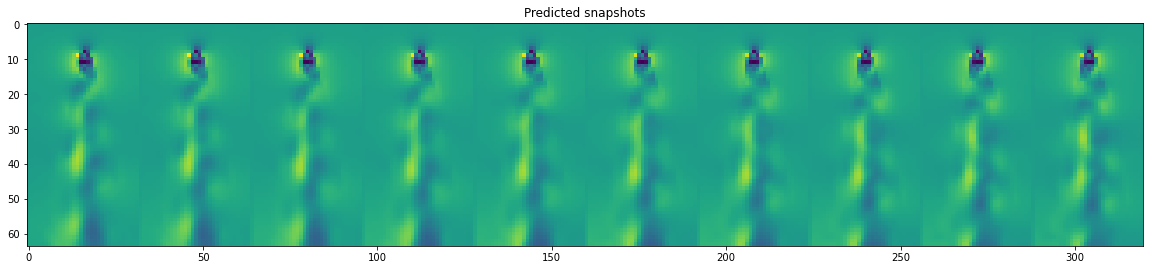

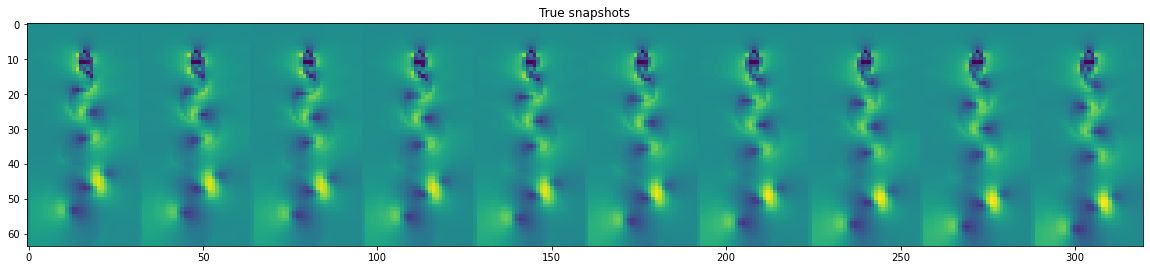

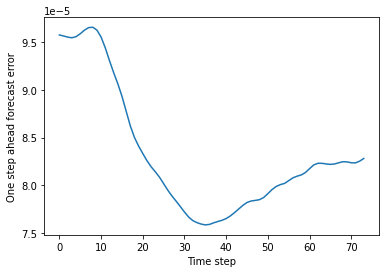

In [5]:
# Import William's solution
# from solutions.linear_regression import LinearRegressor

# Automatically split the data into train, validation, and test sets
dataset= ForecastingDataset(vfield_mag)

# Initialize the model
model = LinearRegressor(method="global", regularization="ridge", regstrength=1.0)

model.fit(
    dataset.flatten_data(dataset.X_train), 
    dataset.flatten_data(dataset.y_train)
)

y_test_pred = dataset.unflatten_data(
    model.predict(dataset.flatten_data(dataset.X_test))
)

plt.figure(figsize=(20, 10))
plt.imshow(np.hstack(y_test_pred[::3][-10:]))
plt.title("Predicted snapshots")

plt.figure(figsize=(20, 10))
plt.imshow(np.hstack(dataset.y_test[::3][-10:]))
plt.title("True snapshots")


mse_vs_time = np.mean((y_test_pred - dataset.y_test)**2, axis=(1, 2))
plt.figure()
plt.plot(mse_vs_time)
plt.ylabel("One step ahead forecast error")
plt.xlabel("Time step")


# Run hyperparameter tuning

Using the validation fold of the von Karman dataset, find the best value of the ridge penalty hyperparameter $\lambda$

In [6]:
regstrengths = np.logspace(-4, 4, 9)

all_mse = []
for regstrength in regstrengths:
    print(f"Training model with regstrength={regstrength}", flush=True)

    model = LinearRegressor(method="global", regularization="ridge", regstrength=regstrength)

    model.fit(
        dataset.flatten_data(dataset.X_train), 
        dataset.flatten_data(dataset.y_train)
    )

    y_val_pred = dataset.unflatten_data(
        model.predict(dataset.flatten_data(dataset.X_val))
    )

    mse = np.mean((y_val_pred - dataset.y_val)**2)
    all_mse.append(mse)

best_regstrength = regstrengths[np.argmin(np.array(all_mse))]

print(f"Best regularize strength: {best_regstrength}")


Training model with regstrength=0.0001
Training model with regstrength=0.001
Training model with regstrength=0.01
Training model with regstrength=0.1
Training model with regstrength=1.0
Training model with regstrength=10.0
Training model with regstrength=100.0
Training model with regstrength=1000.0
Training model with regstrength=10000.0
Best regularize strength: 0.0001


Text(0.5, 0, 'Time step')

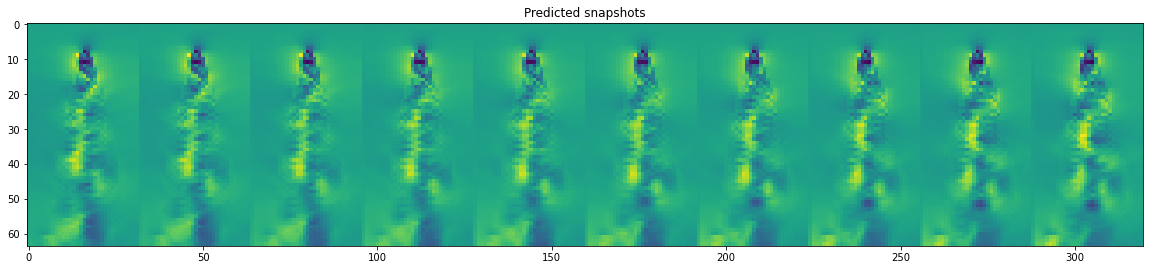

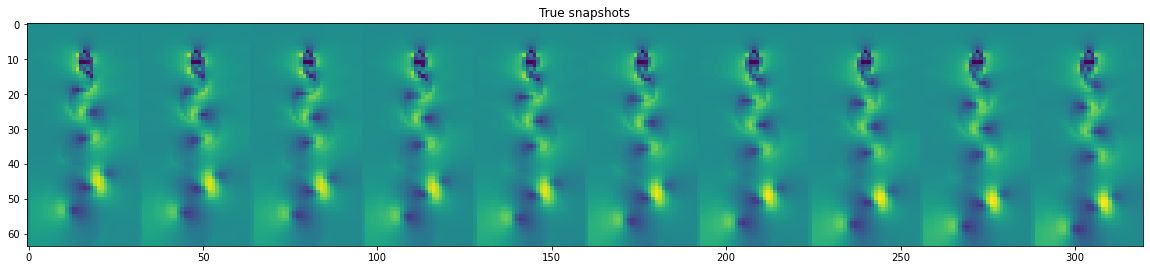

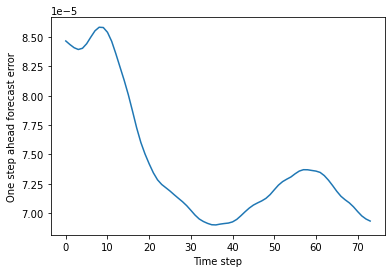

In [7]:
model = LinearRegressor(method="global", regularization="ridge", regstrength=best_regstrength)

model.fit(
    dataset.flatten_data(dataset.X_train), 
    dataset.flatten_data(dataset.y_train)
)

y_test_pred = dataset.unflatten_data(
    model.predict(dataset.flatten_data(dataset.X_test))
)

plt.figure(figsize=(20, 10))
plt.imshow(np.hstack(y_test_pred[::3][-10:]))
plt.title("Predicted snapshots")

plt.figure(figsize=(20, 10))
plt.imshow(np.hstack(dataset.y_test[::3][-10:]))
plt.title("True snapshots")

mse_vs_time = np.mean((y_test_pred - dataset.y_test)**2, axis=(1, 2))
plt.figure()
plt.plot(mse_vs_time)
plt.ylabel("One step ahead forecast error")
plt.xlabel("Time step")

# Improve the featurization of the velocity field dataset

+ Use domain knowledge to calculate nonlinear features of the velocity field, and see if you can get better results for linear regression

In [8]:
def featurize_flowfield(field):
    """
    Compute features of a 2D spatial field. These features are chosen based on the 
    intuition that the input field is a 2D spatial field with time translation 
    invariance.

    The output is an augmented feature along the last axis of the input field.

    Args:
        field (np.ndarray): A 3D array of shape (batch, nx, ny) containing the flow 
            field. The "batch" axis corresponds to time or an arbitrary flow field 
            snapshot index, if you shuffled the data.

    Returns:
        field_features (np.ndarray): An array of shape (batch, nx, ny, M) containing 
            the additional computed features stacked along the last axis
    """
    ############################################################################
    #
    #
    # YOUR CODE HERE
    # Hint: I used concatenate to combine the features together. You have some choice of
    # which features to include, but make sure that your features are computed 
    # separately for each batch element: for each flow field snapshot, they take an 
    # N x N x 2 vector field and return a N x N x D vector field, where D is any integer.
    # My implementation is vectorized along the first (batch) axis
    #
    ############################################################################
    raise NotImplementedError


Text(0.5, 0, 'Time step')

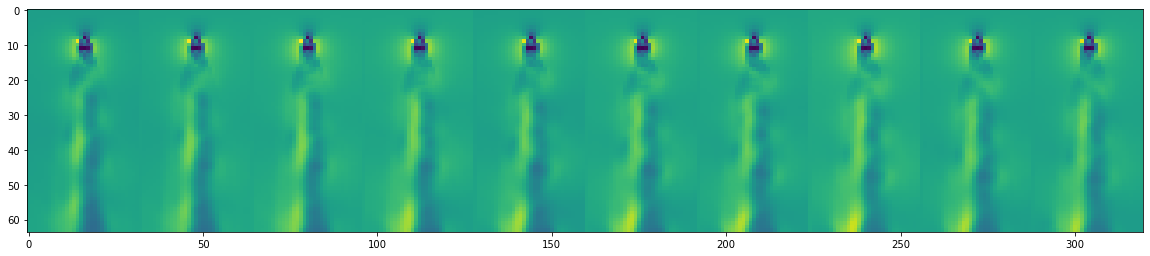

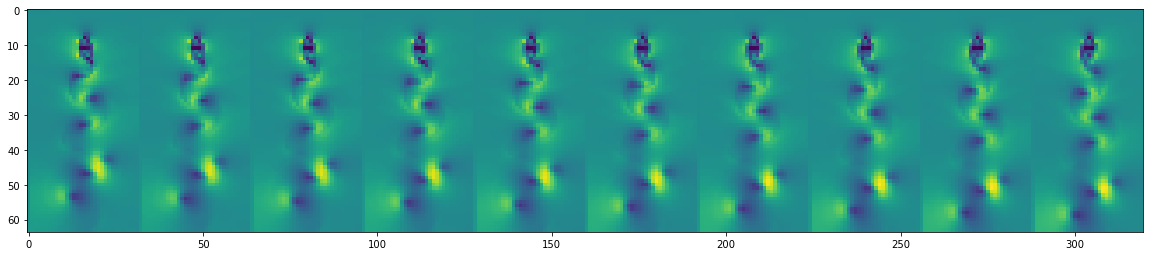

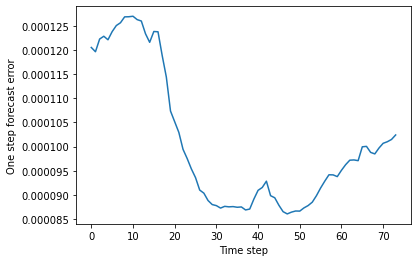

In [9]:
## Import William's solutions
# from solutions.linear_regression import featurize_flowfield

## Pass the data through the featurizer using the keyword argument
dataset = ForecastingDataset(vfield_mag, featurizer=featurize_flowfield)

## Initialize the model
model = LinearRegressor(method="global", regularization="ridge", regstrength=1e5)

model.fit(
    dataset.flatten_data(dataset.X_train), 
    dataset.flatten_data(dataset.y_train)
)

y_test_pred = dataset.unflatten_data(
    model.predict(
        dataset.flatten_data(dataset.X_test)
    )
)

plt.figure(figsize=(20, 10))
plt.imshow(
    np.hstack(y_test_pred[::3][-10:])
)
plt.figure(figsize=(20, 10))
plt.imshow(
    np.hstack(dataset.y_test[::3][-10:])
)


plt.figure()
plt.plot(np.mean((y_test_pred - dataset.y_test)**2, axis=(1, 2)))
plt.ylabel("One step forecast error")
plt.xlabel("Time step")



# Try some other regression models

Make sure you've installed scikit-learn in your local environment

    conda install scikit-learn

These models each have their own sets of hyperparameters. We will use the default values, but you will likely get better results by tuning them. Check out the [scikit-learn documentation](https://scikit-learn.org/stable/supervised_learning.html) for more information about the different models

Text(0.5, 1.0, 'Ground truth')

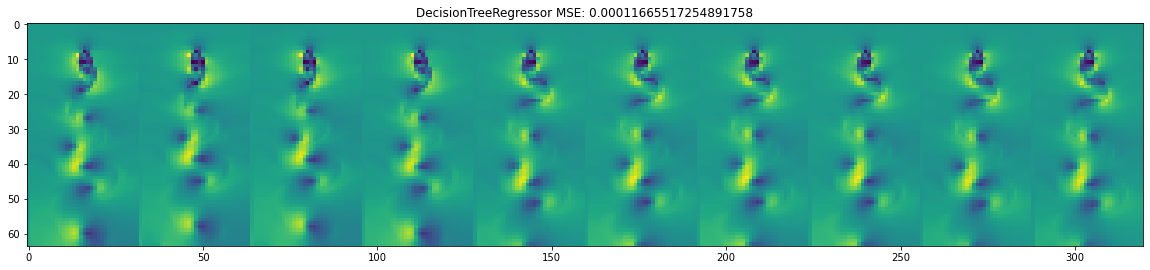

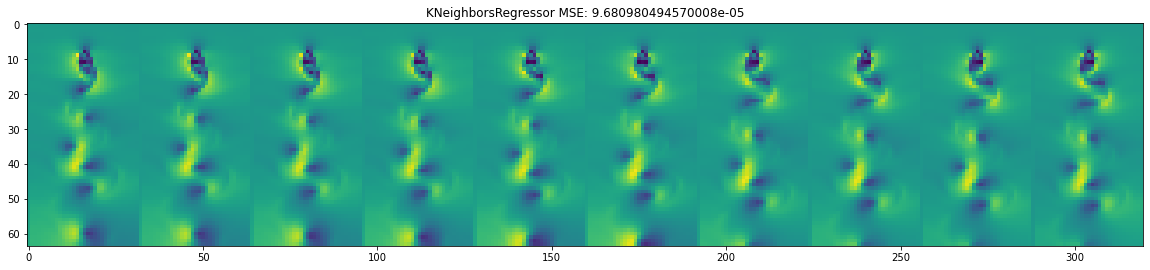

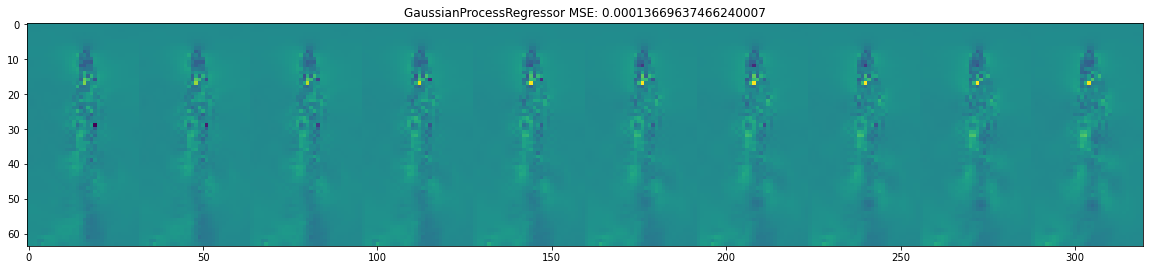

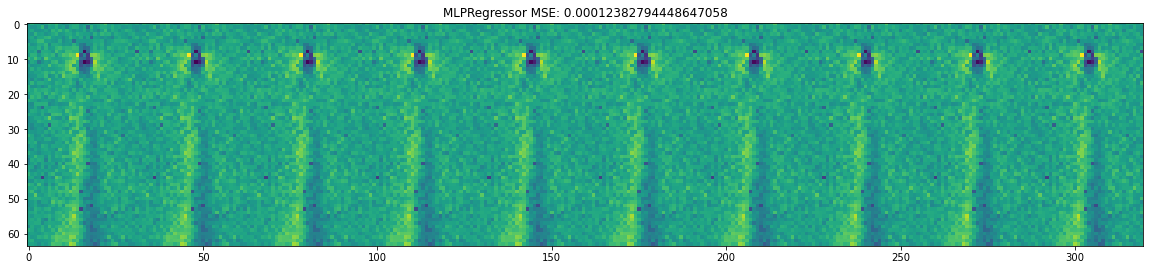

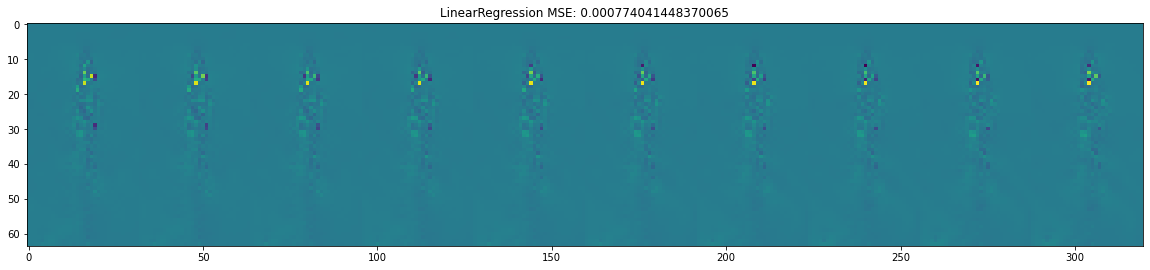

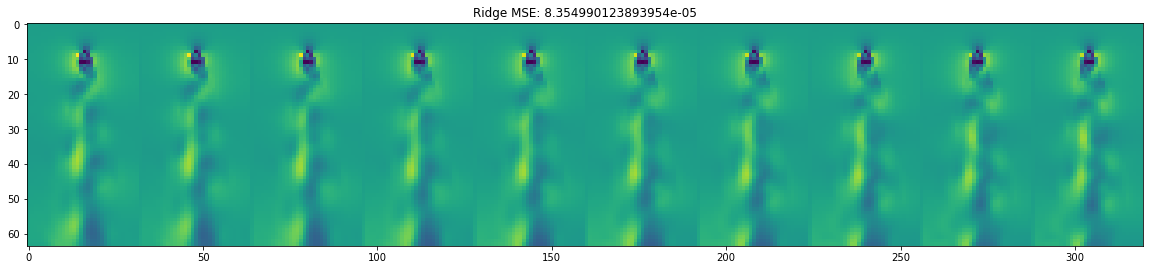

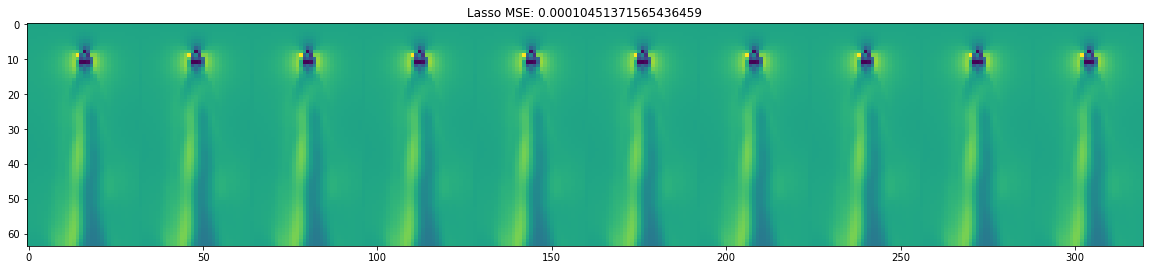

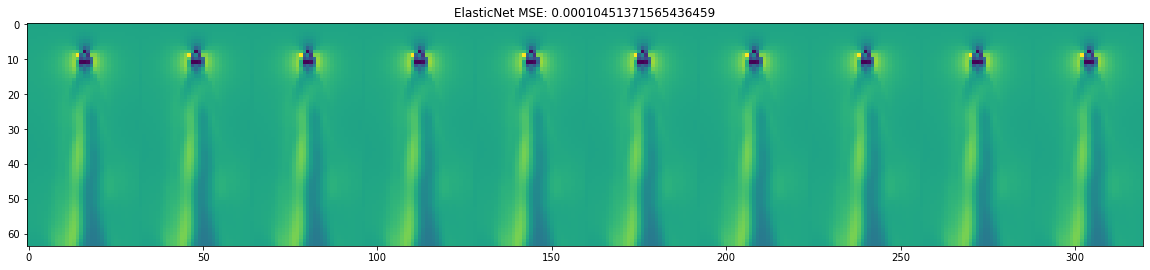

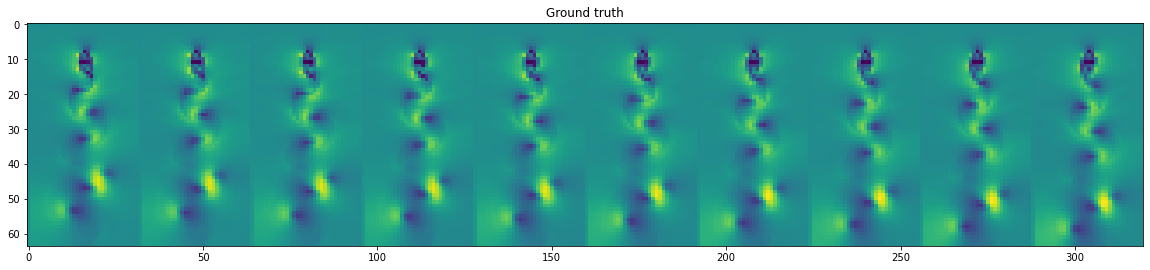

In [72]:

from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor

for model in [DecisionTreeRegressor(), KNeighborsRegressor(), 
                GaussianProcessRegressor(), MLPRegressor(), 
                LinearRegression(), Ridge(), Lasso(), ElasticNet()
            ]:

    name = type(model).__name__
    model.fit(
        dataset.flatten_data(dataset.X_train), 
        dataset.flatten_data(dataset.y_train)
    )


    y_test_pred = dataset.unflatten_data(
        model.predict(
            dataset.flatten_data(dataset.X_test)
        )
    )
    mse = np.mean((y_test_pred - dataset.y_test)**2)

    plt.figure(figsize=(20, 10))
    plt.imshow(np.hstack(y_test_pred[::3][-10:]))
    plt.title(name + " " + f"MSE: {mse}")

plt.figure(figsize=(20, 10))
plt.imshow(np.hstack(dataset.y_test[::3][-10:]))
plt.title("Ground truth")

